In [27]:
# Import Modules
import math
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
import scipy.stats as stats
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from IPython.display import display
from scipy.optimize import minimize

## Batch Surrogate Model

In [28]:
# Data Gathering
data_path = "C:/Users/USER/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
#data_path = "C:/Users/bsjun/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
raw_Data= pd.read_excel(data_path,sheet_name="revised2")
raw_Data['C_B_LA'] = raw_Data['C_B_LA'].apply(lambda x:0 if x<0 else x)
display(raw_Data[:5])

,T_operation,V_operation,E_operation,t_operation2,C_i,C_F_LA,C_A_LA,C_B_LA,C_F_K,C_A_K,C_B_K,V_F,V_A,V_B,CE,SEC,J_LA,Date,V-C
0,35,35,0.5,2.000000,3.247751,2.666598,0.272588,0.000000,2.179980,0.017253,0.686864,1.08,0.98,1.90,15.522230,6.563329,223.608106,230719,32.605990
1,35,35,0.5,2.933333,3.247751,2.470914,0.577139,0.010599,1.660887,0.027207,1.179806,1.03,1.00,1.93,19.058529,5.408487,543.993190,230719,33.106224
2,35,35,0.5,3.933333,3.247751,2.193242,1.063021,0.023075,1.109295,0.041413,1.734744,0.78,1.15,2.00,26.182700,3.958080,1056.942907,230719,33.869779
3,35,35,0.5,4.933333,3.247751,1.570518,1.593019,0.039529,0.649633,0.034028,2.124536,0.58,1.28,2.10,32.334484,3.211235,1337.426543,230719,35.022501
4,35,35,0.5,5.933333,3.247751,0.258292,2.081178,0.055639,0.096276,0.030335,2.372350,0.28,1.40,2.20,37.264021,2.788854,1432.411229,230719,36.822886


### BMED Mass Balance Model


##### Data Treatment

In [29]:
# Delclarate the dataframe
df_MB_columns = ['T_operation','V_operation','E_operation','t_operation2','C_i','C_F_LA','C_A_LA','C_B_LA','V_F','V_A','V_B']
df_MB = raw_Data[df_MB_columns]
df_MB2 = df_MB.copy()
df_MB2['dCF'], df_MB2['dCA'], df_MB2['dCB'] = df_MB['C_i'] - df_MB['C_F_LA'], df_MB['C_A_LA'], df_MB['C_B_LA']
df_MB2['dVF'], df_MB2['dVA'], df_MB2['dVB'] = df_MB['V_F'] - 1, df_MB['V_A'] - 1, df_MB['V_B'] - 2

# Data Set declaration
X = df_MB2[['T_operation','V_operation','E_operation','t_operation2','C_i']].values
Y = df_MB2[['dCF','dCA']].values

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

#### Linear Regression Model

In [30]:
from sklearn.linear_model import LinearRegression

##### dCF surrogate model

In [31]:
# dCF prediction model
ytr_dCF = np.asarray([i[0] for i in Y_train])
yte_dCF = np.asarray([i[0] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dCF = []
model_dCF = list(range(5))
i_dCF = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dCF, yv_dCF = ytr_dCF[train_index], ytr_dCF[val_index]

    model_dCF[i_dCF] = LinearRegression()
    model_dCF[i_dCF].fit(X_t,yt_dCF)
    ypred = model_dCF[i_dCF].predict(X_v)

    r2_cal = r2_score(yv_dCF,ypred)
    r2_dCF.append(r2_cal)
    i_dCF += 1
model_dCF_f = model_dCF[np.argmax(r2_dCF)]
print(f'model coefficient: {model_dCF_f.coef_}')
print(f'model intercept: {model_dCF_f.intercept_}')

yp_dCF_f = model_dCF_f.predict(X_test)
r2_dCF_f = r2_score(yte_dCF,yp_dCF_f)
print(r2_dCF_f)

model coefficient: [0.01078504 0.01896752 0.06568711 0.03943909 0.25374064]
model intercept: -0.8259052834868738
0.4660341441576591


##### dCA surrogate model

In [32]:
# dCA prediction model
ytr_dCA = np.asarray([i[1] for i in Y_train])
yte_dCA = np.asarray([i[1] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dCA = []
model_dCA = list(range(5))
i_dCA = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dCA, yv_dCA = ytr_dCA[train_index], ytr_dCA[val_index]

    model_dCA[i_dCA] = LinearRegression()
    model_dCA[i_dCA].fit(X_t,yt_dCA)
    ypred = model_dCA[i_dCA].predict(X_v)

    r2_cal = r2_score(yv_dCA,ypred)
    r2_dCA.append(r2_cal)
    i_dCA += 1
model_dCA_f = model_dCA[np.argmax(r2_dCA)]
print(f'model coefficient: {model_dCA_f.coef_}')
print(f'model intercept: {model_dCA_f.intercept_}')

yp_dCA_f = model_dCA_f.predict(X_test)
r2_dCA_f = r2_score(yte_dCA,yp_dCA_f)
print(r2_dCA_f)

model coefficient: [ 0.01890759  0.04787047 -0.45235425  0.05129182  0.10007377]
model intercept: -1.5735818017497767
0.4458280021451668


##### dCB surrogate model

In [33]:
# dCB prediction model
ytr_dCB = np.asarray([i[2] for i in Y_train])
yte_dCB = np.asarray([i[2] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dCB = []
model_dCB = list(range(5))
i_dCB = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dCB, yv_dCB = ytr_dCB[train_index], ytr_dCB[val_index]

    model_dCB[i_dCB] = LinearRegression()
    model_dCB[i_dCB].fit(X_t,yt_dCB)
    ypred = model_dCB[i_dCB].predict(X_v)

    r2_cal = r2_score(yv_dCB,ypred)
    r2_dCB.append(r2_cal)
    i_dCB += 1
model_dCB_f = model_dCB[np.argmax(r2_dCB)]
print(f'model coefficient: {model_dCB_f.coef_}')
print(f'model intercept: {model_dCB_f.intercept_}')

yp_dCB_f = model_dCB_f.predict(X_test)
r2_dCB_f = r2_score(yte_dCB,yp_dCB_f)
print(r2_dCB_f)

IndexError: index 2 is out of bounds for axis 0 with size 2

##### dVF surrogate model

In [ ]:
# dVF prediction model
ytr_dVF = np.asarray([i[3] for i in Y_train])
yte_dVF = np.asarray([i[3] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dVF = []
model_dVF = list(range(5))
i_dVF = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dVF, yv_dVF = ytr_dVF[train_index], ytr_dVF[val_index]

    model_dVF[i_dVF] = LinearRegression()
    model_dVF[i_dVF].fit(X_t,yt_dVF)
    ypred = model_dVF[i_dVF].predict(X_v)

    r2_cal = r2_score(yv_dVF,ypred)
    r2_dVF.append(r2_cal)
    i_dVF += 1
model_dVF_f = model_dVF[np.argmax(r2_dVF)]
print(f'model coefficient: {model_dVF_f.coef_}')
print(f'model intercept: {model_dVF_f.intercept_}')

yp_dVF_f = model_dVF_f.predict(X_test)
r2_dVF_f = r2_score(yte_dVF,yp_dVF_f)
print(r2_dVF_f)

IndexError: index 3 is out of bounds for axis 0 with size 3

##### dVA surrogate model

In [ ]:
# dVA prediction model
ytr_dVA = np.asarray([i[4] for i in Y_train])
yte_dVA = np.asarray([i[4] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dVA = []
model_dVA = list(range(5))
i_dVA = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dVA, yv_dVA = ytr_dVA[train_index], ytr_dVA[val_index]

    model_dVA[i_dVA] = LinearRegression()
    model_dVA[i_dVA].fit(X_t,yt_dVA)
    ypred = model_dVA[i_dVA].predict(X_v)

    r2_cal = r2_score(yv_dVA,ypred)
    r2_dVA.append(r2_cal)
    i_dVA += 1
model_dVA_f = model_dVA[np.argmax(r2_dVA)]
print(f'model coefficient: {model_dVA_f.coef_}')
print(f'model intercept: {model_dVA_f.intercept_}')

yp_dVA_f = model_dVA_f.predict(X_test)
r2_dVA_f = r2_score(yte_dVA,yp_dVA_f)
print(r2_dVA_f)

model coefficient: [ 0.00753789  0.0121231  -0.0800759  -0.00502483 -0.0237931 ]
model intercept: -0.39422530026386915
0.6369405740362585


##### dVB surrogate model

In [ ]:
# dVB prediction model
ytr_dVB = np.asarray([i[5] for i in Y_train])
yte_dVB = np.asarray([i[5] for i in Y_test])
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)
r2_dVB = []
model_dVB = list(range(5))
i_dVB = 0

for train_index, val_index in kfold.split(X_train):
    X_t, X_v = X_train[train_index], X_train[val_index]
    yt_dVB, yv_dVB = ytr_dVB[train_index], ytr_dVB[val_index]

    model_dVB[i_dVB] = LinearRegression()
    model_dVB[i_dVB].fit(X_t,yt_dVB)
    ypred = model_dVB[i_dVB].predict(X_v)

    r2_cal = r2_score(yv_dVB,ypred)
    r2_dVB.append(r2_cal)
    i_dVB += 1
model_dVB_f = model_dVB[np.argmax(r2_dVB)]
print(f'model coefficient: {model_dVB_f.coef_}')
print(f'model intercept: {model_dVB_f.intercept_}')

yp_dVB_f = model_dVB_f.predict(X_test)
r2_dVB_f = r2_score(yte_dVB,yp_dVB_f)
print(r2_dVB_f)

model coefficient: [ 0.00687991  0.00144926  0.02867059  0.00097745 -0.00737902]
model intercept: -0.2841550830241642
0.01987704113509048


#### ANN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [36]:
# Tensor
X_ts = torch.tensor(X, dtype=torch.float32)
Y_ts = torch.tensor(Y, dtype=torch.float32)

# # Data split
# Xts_train, Xts_test, Yts_train, Yts_test = train_test_split(X_ts, Y_ts, test_size = 0.2, random_state=42)
# kfold = KFold(n_splits=5, shuffle=True, random_state= 42)

# model_ANN = list(range(5))
# loss_ANN = list(range(5))
# iter = 0
# for train_index, val_index in kfold.split(Xts_train):
    
#     X_t, X_v = X_ts[train_index], X_ts[val_index]
#     Y_t, Y_v = Y_ts[train_index], Y_ts[val_index]

#     model = nn.Sequential(
#         nn.Linear(5,10),
#         nn.ReLU(),
#         nn.Linear(10,12),
#         nn.ReLU(),
#         nn.Linear(12,6),
#         nn.ReLU(),
#         nn.Linear(6,3)
#     )

#     criterion = nn.MSELoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.01)

#     num_epochs = 10000
    
#     for epoch in range(num_epochs):
#         for i in range(len(X_t)):
#             inputs = X_t[i]
#             targets = Y_t[i]

#             outputs = model(inputs)

#             loss = criterion(outputs, targets)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         if (epoch + 1) % 100 == 0:
#             print(f'Fold [{iter+1}/{5}], Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')
#     model_ANN[iter] = model
#     loss_ANN[iter] = loss    
        
#     iter += 1

model = nn.Sequential(
        nn.Linear(5,10),
        nn.ReLU(),
        nn.Linear(10,8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,2)
    )

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1000000

for epoch in range(num_epochs):
    for i in range(len(X_ts)):
        inputs = X_ts
        targets = Y_ts

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')



Epoch [100/1000000], Loss: 0.07082884
Epoch [200/1000000], Loss: 0.03049816
Epoch [300/1000000], Loss: 0.02058560
Epoch [400/1000000], Loss: 0.01754943
Epoch [500/1000000], Loss: 0.01481220
Epoch [600/1000000], Loss: 0.03874153
Epoch [700/1000000], Loss: 0.02754946
Epoch [800/1000000], Loss: 0.01576553
Epoch [900/1000000], Loss: 0.00986634
Epoch [1000/1000000], Loss: 0.01309272
Epoch [1100/1000000], Loss: 0.01155855
Epoch [1200/1000000], Loss: 0.00999372
Epoch [1300/1000000], Loss: 0.01005325
Epoch [1400/1000000], Loss: 0.01120324
Epoch [1500/1000000], Loss: 0.01065970
Epoch [1600/1000000], Loss: 0.01007186
Epoch [1700/1000000], Loss: 0.00961815
Epoch [1800/1000000], Loss: 0.01012354
Epoch [1900/1000000], Loss: 0.01096074
Epoch [2000/1000000], Loss: 0.01000075
Epoch [2100/1000000], Loss: 0.00927290
Epoch [2200/1000000], Loss: 0.00889485
Epoch [2300/1000000], Loss: 0.01033240
Epoch [2400/1000000], Loss: 0.00927964
Epoch [2500/1000000], Loss: 0.01169481
Epoch [2600/1000000], Loss: 0.0095

In [1]:
# torch detachment
def tor_dt(x):
    return x.detach().numpy()

# loss_ANN_tr = np.asarray(list(map(tor_dt,loss_ANN)))
# print(loss_ANN_tr)
# model_ANN_f = model_ANN[np.argmin(loss_ANN_tr)]

Y_pred = model(X_ts)
Y_tensor_t = Y_ts.detach().numpy()
Y_pred_t = Y_pred.detach().numpy()

for i in range(2):
    plt.plot([j[i] for j in Y_tensor_t],[j[i] for j in Y_tensor_t])
    plt.scatter([j[i] for j in Y_tensor_t],[j[i] for j in Y_pred_t])
    plt.show()

torch.save(model.state_dict(), "model_total data_v0.pt")

NameError: name 'model' is not defined

In [ ]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter('ignore')
        return model.predict(X, return_std=True)

In [ ]:
# Expected improvement acquisition function
def acquisition(X, Xsamples, model, xi):
    # calculate the best surrgate score found so far
    yhat, _ = surrogate(model, X)
    best1, best2 = min([i[0] for i in yhat]), max([i[1] for i in yhat])

    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    # Calculate the expected improvement (EI)
    # Clip std to avoid division by zero
    std = np.clip(std, 1e-9, None)  # Replace None with a suitable upper bound if needed
    std2 = [i[0] for i in std]
    z = score2 - best / std2
    ei = (score2 - best) * stats.norm.cdf(z) + std2 * stats.norm.pdf(z)
    return ei

In [ ]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # grid search, generate samples
    Tsample = np.linspace(25,35,31)
    Vsample = np.linspace(10,35,31)
    Esample = np.linspace(0.25,1,31)
    Fsample = np.linspace(-0.1,5.2,31)
    Asample = np.linspace(-0.1,2.2,31)
    Xsamples = np.asarray(list(itertools.product(Tsample,Vsample,Esample,Fsample,Asample)))
    
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]

In [ ]:
# plot real observation vs surrogate function
def plot(X, y, model):
    # Split inputs
    Xe1 = [X[i][0] for i in range(len(X))]
    Xe2 = [X[i][1] for i in range(len(X))]
    Xe3 = [X[i][2] for i in range(len(X))]
    ye1 = [y[i][0] for i in range(len(y))]
    ye2 = [y[i][1] for i in range(len(y))]

    # scatter plot of imputs
    fig, axes = plt.subplots(2,3)
    axes[0,0].scatter(Xe1, ye1)
    axes[0,1].scatter(Xe2, ye1)
    axes[0,2].scatter(Xe3, ye1)
    axes[1,0].scatter(Xe1, ye2)
    axes[1,1].scatter(Xe2, ye2)
    axes[1,2].scatter(Xe3, ye2)

    # line plot of surragte function acorss domain
    Xp1 = np.append(Xe1,10 + 10*np.random.random(20))
    Xp2 = np.append(Xe2,2*np.random.random(20))
    Xp3 = np.append(Xe3,-10 + 20*np.random.random(20))
    Xpred = np.asarray(list(itertools.product(Xp1,Xp2,Xp3)))

    ypred, _ = surrogate(model, Xpred)
    yp1 = [i[0] for i in ypred]
    yp2 = [i[1] for i in ypred]

    Xpl1 = [i[0] for i in Xpred]
    Xpl2 = [i[1] for i in Xpred]
    Xpl3 = [i[2] for i in Xpred]

    axes[0,0].scatter(Xpl1, yp1, s=1)
    axes[0,1].scatter(Xpl2, yp1, s=1)
    axes[0,2].scatter(Xpl3, yp1, s=1)
    axes[1,0].scatter(Xpl1, yp2, s=1)
    axes[1,1].scatter(Xpl2, yp2, s=1)
    axes[1,2].scatter(Xpl3, yp2, s=1)
    # show the plot
    plt.show()

In [2]:
T, V, E, Ci, ALA = [i[0] for i in X], [i[1] for i in X], [i[2] for i in X], [i[3] for i in X], [i[4] for i in X]
SEC, JLA = [i[0] for i in Y], [i[1] for i in Y]

# Z-score normalization
zX = list(range(len(X)))
zY = list(range(len(Y)))

for i in range(len(zX)):
    iX = [(T[i]-np.average(T))/np.std(T),(V[i]-np.average(V))/np.std(V),(E[i]-np.average(E))/np.std(E),(Ci[i]-np.average(Ci))/np.std(Ci),(ALA[i]-np.average(ALA))/np.std(ALA)]
    iY = [(SEC[i]-np.average(SEC))/np.std(SEC),(JLA[i]-np.average(JLA))/np.std(JLA)]
    zX[i], zY[i] = iX, iY
zX, zY = np.asarray(zX), np.asarray(zY)

# min-max normalization
mX = list(range(len(X)))
mY = list(range(len(Y)))

for i in range(len(mX)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(ALA[i]-np.min(ALA))/(np.max(ALA)-np.min(ALA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mX[i], mY[i] = iX, iY
mX, mY = np.asarray(mX), np.asarray(mY)

thr = np.inf
thr1 = thr
thr2 = -thr
over_thr1 = np.where(np.asarray([i[0] for i in zY]) > thr1)
over_thr2 = np.where(np.asarray([i[1] for i in zY]) > thr1)
over_thr3 = np.where(np.asarray([i[0] for i in zY]) < thr2)
over_thr4 = np.where(np.asarray([i[1] for i in zY]) < thr2)
over_thr = np.unique(np.concatenate((np.asarray(over_thr1)[0], np.asarray(over_thr2)[0], np.asarray(over_thr3)[0], np.asarray(over_thr4)[0])))
rzX = zX[~np.isin(np.arange(zX.shape[0]), over_thr), :]
rzY = zY[~np.isin(np.arange(zY.shape[0]), over_thr), :]

X_train, X_test, Y_train, Y_test = train_test_split(mX,mY,test_size = 0.2, random_state=24)

rs_number = np.arange(0,100,1)
fun1 = []
alpha1 = []

for i in range(len(rs_number)):
    
    # alpha optimization with 5-fold cross validation
    alp = [1e-4, 1e-4]

    # optimize the parameter alpha of gaussian process regressor
    def alpha_GP1_opt(alp1):
        kfold = KFold(n_splits=5, shuffle=True, random_state= rs_number[i])
        mse_scores_1 = []
        for train_index, test_index in kfold.split(X_train):
            X_train2, X_test2 = X_train[train_index], X_train[test_index]
            Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

            GPR1 = GaussianProcessRegressor(alpha=alp1)
            GPR1.fit(X_train2, [i[0] for i in Y_train2])
            ypred1 = GPR1.predict(X_test2)

            mse_1 = mse(np.asarray([i[0] for i in Y_test2]),ypred1)
            mse_scores_1.append(mse_1)
        
        return sum(mse_scores_1) / len(mse_scores_1)
    
    res1 = minimize(alpha_GP1_opt,alp[0],bounds=[(1e-10,10)])
    alpha1.append(res1.x)
    fun1.append(res1.fun)

fun2 = []
alpha2 = []
for i in range(len(rs_number)):
    def alpha_GP2_opt(alp2):
        kfold = KFold(n_splits=5, shuffle=True, random_state= rs_number[i])
        mse_scores_2 = []
        for train_index, test_index in kfold.split(X_train):
            X_train2, X_test2 = X_train[train_index], X_train[test_index]
            Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

            GPR2 = GaussianProcessRegressor(alpha=alp2)
            GPR2.fit(X_train2, [i[1] for i in Y_train2])
            ypred2 = GPR2.predict(X_test2)

            mse_2 = mse(np.asarray([i[1] for i in Y_test2]),ypred2)
            mse_scores_2.append(mse_2)
        
        return sum(mse_scores_2) / len(mse_scores_2)


    res2 = minimize(alpha_GP2_opt,alp[1],bounds=[(1e-10,10)])
    alpha2.append(res2.x)
    fun2.append(res2.fun)

plt.scatter(rs_number,fun1)
plt.scatter(rs_number,fun2)

NameError: name 'X' is not defined

In [ ]:
fun1 = np.asarray(fun1)
fun2 = np.asarray(fun2)

fun_min = np.argmin(fun1*fun2)

print(fun_min)

alp1_opt = alpha1[fun_min]
alp2_opt =  alpha2[fun_min]
print(alp1_opt)
print(alp2_opt)

35
[0.00304866]
[0.00115597]


r2_1:0.3288873900961281, r2_2:-0.1249090599489937


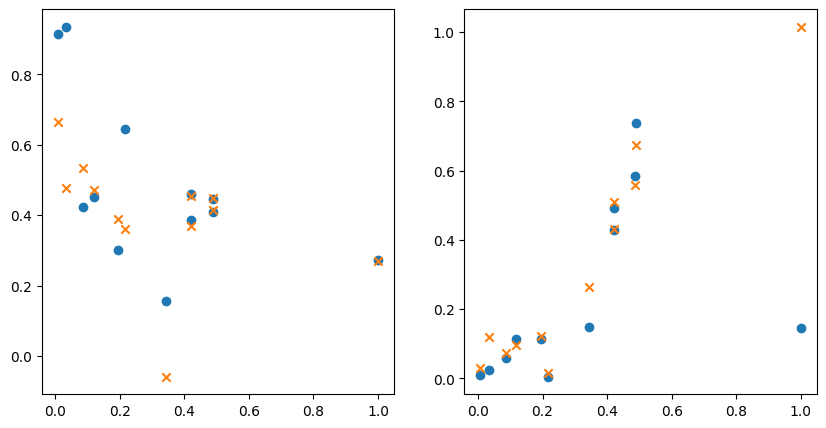

In [ ]:
GPR1 = GaussianProcessRegressor(alpha=alp1_opt)
GPR1.fit(X_train, [i[0] for i in Y_train])
ypred1,_ = GPR1.predict(X_test,[i[0] for i in Y_test])

GPR2 = GaussianProcessRegressor(alpha=alp2_opt)
GPR2.fit(X_train, [i[1] for i in Y_train])
ypred2,_ = GPR2.predict(X_test,[i[1] for i in Y_test])

fig, axs = plt.subplots(1,2, figsize =(10,5))

axs[0].scatter([i[4] for i in X_test],[i[0] for i in Y_test],marker='o')
axs[0].scatter([i[4] for i in X_test],ypred1,marker='x')

axs[1].scatter([i[4] for i in X_test],[i[1] for i in Y_test],marker='o')
axs[1].scatter([i[4] for i in X_test],ypred2,marker='x')

r2_1 = r2_score([i[0] for i in Y_test],ypred1)
r2_2 = r2_score([i[1] for i in Y_test],ypred2)
print(f'r2_1:{r2_1}, r2_2:{r2_2}')


r2_1:0.6199991304738256, r2_2:0.798089304623816


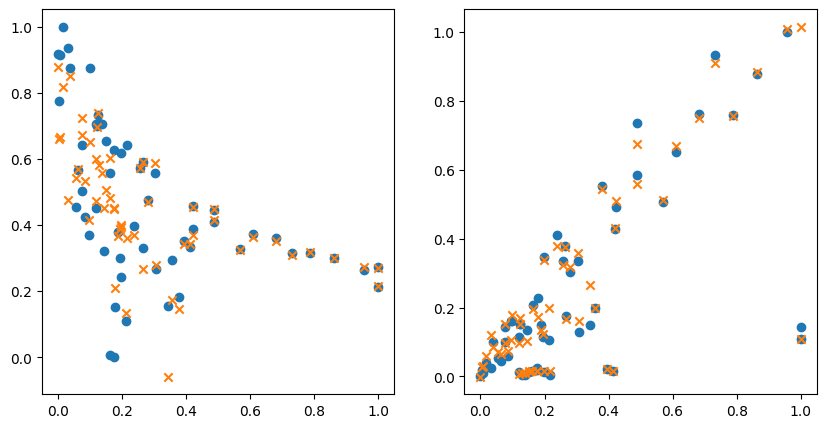

In [ ]:
yt1,_ = GPR1.predict(mX,[i[0] for i in mY])
yt2,_ = GPR2.predict(mX,[i[1] for i in mY])

fig, axs = plt.subplots(1,2, figsize =(10,5))

axs[0].scatter([i[4] for i in mX],[i[0] for i in mY],marker='o')
axs[0].scatter([i[4] for i in mX],yt1,marker='x')

axs[1].scatter([i[4] for i in mX],[i[1] for i in mY],marker='o')
axs[1].scatter([i[4] for i in mX],yt2,marker='x')

r2_1 = r2_score([i[0] for i in mY],yt1)
r2_2 = r2_score([i[1] for i in mY],yt2)
print(f'r2_1:{r2_1}, r2_2:{r2_2}')

In [ ]:
def func_maximize(x,w):
    x4 = x[3] * x[4]
    rx = [(x[0]-np.min(T))/(np.max(T)-np.min(T)),(x[1]-np.min(V))/(np.max(V)-np.min(V)),(x[2]-np.min(E))/(np.max(E)-np.min(E)),(x[3]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(x4-np.min(ALA))/(np.max(ALA)-np.min(ALA))]
    yhat1 = GPR1.predict([rx], return_std=False)
    yhat2 = GPR2.predict([rx], return_std=False)
    return w*yhat1 + (1-w)*(1-yhat2)


w0 = np.arange(0,1,0.05)
sol = []

for i in w0:
    x0 = [30, 22.5, 0.625, 3, 0.5]
    bounds = [(25,35),(10,35),(0.25,1),(0,3.5),(0,1)]

    res = minimize(func_maximize,x0,bounds=bounds,args=(i))
    sol.append(res.x)

print(sol)

[array([32.66788074, 35.        ,  0.66513054,  2.16746697,  1.        ]), array([32.77192573, 35.        ,  0.66436664,  2.15923816,  1.        ]), array([32.88730092, 35.        ,  0.66350787,  2.15094422,  1.        ]), array([33.01712451, 35.        ,  0.66254775,  2.1427148 ,  1.        ]), array([33.16423824, 35.        ,  0.66148011,  2.13470759,  1.        ]), array([33.33268196, 35.        ,  0.66028858,  2.12713286,  1.        ]), array([33.52824783, 35.        ,  0.65894192,  2.12027993,  1.        ]), array([33.75888332, 35.        ,  0.65743472,  2.11463606,  1.        ]), array([34.0348021 , 35.        ,  0.65572756,  2.11087556,  1.        ]), array([34.37228063, 35.        ,  0.6537713 ,  2.11000374,  1.        ]), array([34.7913669 , 35.        ,  0.65148688,  2.11348124,  1.        ]), array([35.        , 34.92044163,  0.64605645,  2.10230389,  1.        ]), array([35.        , 31.85897274,  0.62264548,  1.98936062,  1.        ]), array([30.15002655, 24.75134435,  0.4

In [ ]:
def func_calc(x):
    x4 = x[3] * x[4]
    rx = [(x[0]-np.min(T))/(np.max(T)-np.min(T)),(x[1]-np.min(V))/(np.max(V)-np.min(V)),(x[2]-np.min(E))/(np.max(E)-np.min(E)),(x[3]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(x4-np.min(ALA))/(np.max(ALA)-np.min(ALA))]
    yhat1 = GPR1.predict([rx], return_std=False)
    yhat2 = GPR2.predict([rx], return_std=False)

    y1 = (np.max(SEC)-np.min(SEC))*yhat1 + np.min(SEC)
    y2 = (np.max(JLA)-np.min(JLA))*yhat2 + np.min(JLA)
    return [y1, y2]

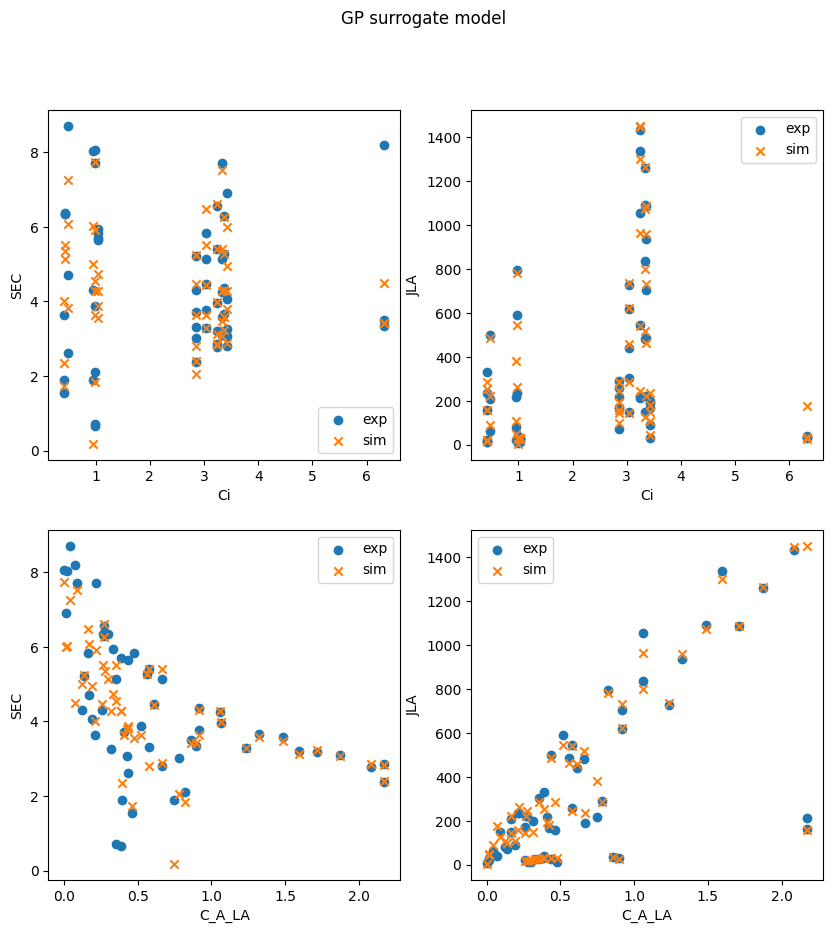

In [ ]:
# Result visualization
yt1,_ = GPR1.predict(mX,[i[0] for i in mY])
yt2,_ = GPR2.predict(mX,[i[1] for i in mY])

ry1 = (np.max(SEC)-np.min(SEC))*yt1 + np.min(SEC)
ry2 = (np.max(JLA)-np.min(JLA))*yt2 + np.min(JLA)

fig, axs = plt.subplots(2,2, figsize =(10,10))

axs[0][0].scatter([i[3] for i in X],[i[0] for i in Y],marker='o', label='exp')
axs[0][0].scatter([i[3] for i in X],ry1,marker='x', label='sim')
axs[0][0].set_xlabel('Ci')
axs[0][0].set_ylabel('SEC')
axs[0][0].legend()

axs[0][1].scatter([i[3] for i in X],[i[1] for i in Y],marker='o', label='exp')
axs[0][1].scatter([i[3] for i in X],ry2,marker='x', label='sim')
axs[0][1].legend()
axs[0][1].set_xlabel('Ci')
axs[0][1].set_ylabel('JLA')
axs[0][1].legend()

axs[1][0].scatter([i[4] for i in X],[i[0] for i in Y],marker='o', label='exp')
axs[1][0].scatter([i[4] for i in X],ry1,marker='x', label='sim')
axs[1][0].set_xlabel('C_A_LA')
axs[1][0].set_ylabel('SEC')
axs[1][0].legend()

axs[1][1].scatter([i[4] for i in X],[i[1] for i in Y],marker='o', label='exp')
axs[1][1].scatter([i[4] for i in X],ry2,marker='x', label='sim')
axs[1][1].legend()
axs[1][1].set_xlabel('C_A_LA')
axs[1][1].set_ylabel('JLA')
axs[1][1].legend()

plt.suptitle('GP surrogate model')
plt.show()

In [ ]:
solution = np.asarray(sol)
rdf = pd.DataFrame(solution)

rdf.columns = ['T_operation','V_operation','E_operation','Ci','C_A_LA']
rdf['w_factor'] = w0
new_columns = ['w_factor','T_operation','V_operation','E_operation','Ci','C_A_LA']
rdf2 = rdf[new_columns]

ans_SEC = np.zeros(len(w0))
ans_JLA = np.zeros(len(w0))

for i in range(len(w0)):
    ans = func_calc(sol[i])
    ans_SEC[i] = ans[0][0]
    ans_JLA[i] = ans[1][0]
rdf3 = rdf2.copy()
rdf3['SEC'] = np.array(ans_SEC)
rdf3['JLA'] = np.array(ans_JLA)
display(rdf3)

,w_factor,T_operation,V_operation,E_operation,Ci,C_A_LA,SEC,JLA
0,0.00,32.667881,35.000000,0.665131,2.167467,1.0,2.397418,1694.569836
1,0.05,32.771926,35.000000,0.664367,2.159238,1.0,2.369733,1694.441508
2,0.10,32.887301,35.000000,0.663508,2.150944,1.0,2.340307,1694.015900
3,0.15,33.017125,35.000000,0.662548,2.142715,1.0,2.308749,1693.213780
4,0.20,33.164238,35.000000,0.661480,2.134708,1.0,2.274738,1691.931219
5,0.25,33.332682,35.000000,0.660289,2.127133,1.0,2.237764,1690.023920
6,0.30,33.528248,35.000000,0.658942,2.120280,1.0,2.197040,1687.279865
7,0.35,33.758883,35.000000,0.657435,2.114636,1.0,2.151510,1683.384956
8,0.40,34.034802,35.000000,0.655728,2.110876,1.0,2.099738,1677.864631
9,0.45,34.372281,35.000000,0.653771,2.110004,1.0,2.039269,1669.917779


In [ ]:
ans = func_calc([35,35,0.5,3.247751,0.64])
print(ans)

[array([2.85972944]), array([1445.76790344])]


## Two-Stage Optimizer